# AdaBoost-LSTM

In [0]:
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU 
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [0]:
series = pd.read_csv('CrudeOilPrice04122019.csv', header=0 )

In [0]:
series.columns

Index(['Date', 'CrudeOilPriceUSD'], dtype='object')

In [0]:
series.columns = ['Date','OilP']

In [0]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 2 columns):
Date    2265 non-null object
OilP    2265 non-null float64
dtypes: float64(1), object(1)
memory usage: 35.5+ KB


In [0]:
series.describe()

,OilP
count,2265.000000
mean,80.923099
std,27.275890
min,25.810000
25%,56.510000
50%,77.180000
75%,110.320000
max,130.430000


In [0]:
series.shape

(2265, 2)

In [0]:
srs = series['OilP']
srs.head()

0    107.95
1    107.97
2    107.16
3    107.95
4    109.58
Name: OilP, dtype: float64

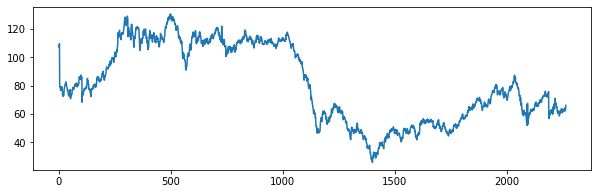

In [0]:

pyplot.figure(figsize=(10,3))
pyplot.plot(srs.values)
pyplot.show()

In [0]:
srs = np.array(srs).reshape((-1, 1))

# Data preparation 
Normalizing the data using minmax scaler

In [0]:
from sklearn import preprocessing
# normalize features - 

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(srs)
srs = pd.DataFrame(scaled)

[[107.95]
 [107.97]
 [107.16]
 ...
 [ 62.25]
 [ 64.35]
 [ 66.1 ]]


Fix the moving window size to be 2. For this purpose we use pandas shift function that shifts the entire column by the number we specify. In the below code snippet, we shifted the column up by 1 (hence used -1. If we want to shift it down by 1, we will have to use +1) and then concatenate that to the original data.


I dropped all the rows that contain the Nan values in the code snippet.

In [0]:
# Fix the moving window size to be 2
window_size = 5

srs_s = srs.copy()
for i in range(window_size):
    srs = pd.concat([srs, srs_s.shift(-(i+1))], axis = 1)
 # I dropped all the rows that contain the Nan values in the code snippet.   
srs.dropna(axis=0, inplace=True)

The last column in the below table becomes the target y and the first five columns become our input x features. 

In [0]:
srs.head()

,0,0,0,0,0,0
0,0.570254,0.570637,0.555152,0.570254,0.601415,0.045307
1,0.570637,0.555152,0.570254,0.601415,0.045307,0.015485
2,0.555152,0.570254,0.601415,0.045307,0.015485,0.010132
3,0.570254,0.601415,0.045307,0.015485,0.010132,0.008029
4,0.601415,0.045307,0.015485,0.010132,0.008029,-0.026955


In [0]:
# We can give the columns names, as in, 'a', 'b', 'c', 'd', 'e', for x-columns 1-5 and the sixth column 'y'
src.column = ['a', 'b', 'c', 'd', 'e', 'y'] 

In [0]:
srs.shape

(2260, 6)

Split Dataset into the 75% and 25% respectively for training set and test set

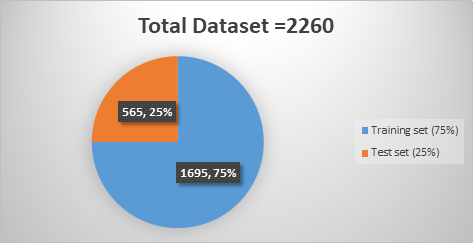

In [0]:
nrow = round(0.75*srs.shape[0])

In [0]:
nrow

1695

In [0]:
train = srs.iloc[:nrow, :]
test = srs.iloc[nrow:,:]

Shuffle the data to make sure that the training/test sets are representative. 

In [0]:
from sklearn.utils import shuffle
train = shuffle(train)

In [0]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [0]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [0]:
train_X.shape


(1695, 5)

In [0]:
train_y.shape


(1695,)

In [0]:
test_X.shape


(565, 5)

In [0]:
test_y.shape

(565,)

This input data layer must be reformatted into three-dimensional (3D) vectors to match the architecture of the LSTM model. The input vector (3D) comprises of samples, time steps, and features with the shape num_samples, num_timesteps, and num_features, respectively.
In this case we have num of time steps = 5 and num_features = 1 

we want to identify all the patterns that exist between each of the previous values in the window to predict the current time step!

In [0]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [0]:
train_X.shape


(1695, 5, 1)

In [0]:
train_y.shape


(1695,)

In [0]:
test_X.shape


(565, 5, 1)

In [0]:
test_y.shape

(565,)

In [0]:
from sklearn.ensemble import AdaBoostRegressor
from keras.wrappers.scikit_learn import KerasRegressor

Below is the model architecture used that is quite self-explanatory—(Its a double stacked LSTM layers with the output from the first LSTM at each time step is being fed to the second LSTM)

In [0]:
# Define the LSTM model.Using a two layered LSTM architecture with a dense output layer.
def create_model(init_type='mse', optimizer='adam'):
  model = Sequential()
  model.add(LSTM(input_shape = (5,1), output_dim= 5, return_sequences = True))
  model.add(Dropout(0.5))
  model.add(LSTM(256))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation("linear"))
  model.compile(loss="mse", optimizer="adam")
  
  return model

In [0]:
lstm_estimator = KerasRegressor(build_fn= create_model, epochs=100, batch_size=10, verbose=1)

In [0]:
adab_lstm = AdaBoostRegressor(base_estimator= lstm_estimator)
rescaled_train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)

adab_lstm.fit(rescaled_train_X, train_y)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 9s 5ms/step - loss: 0.0366
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0217
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0177
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0188
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0198
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0176
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0187
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0190
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0167
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0175
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0172
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 9s 5ms/step - loss: 0.0368
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0217
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0211
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0225
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0205
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0203
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0192
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0182
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0176
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0172
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0157
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 9s 6ms/step - loss: 0.0418
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0207
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0224
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0204
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0238
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0213
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0194
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0192
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0182
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0163
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0176
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.0414
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0219
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0221
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0218
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0207
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0227
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0208
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0192
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0185
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0184
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0177
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.0457
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0231
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0236
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0213
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0230
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0225
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0219
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0196
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0163
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0176
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0192
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 10s 6ms/step - loss: 0.0483
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0212
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0224
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0214
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0215
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0201
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0202
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0198
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0196
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0181
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0155
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 11s 6ms/step - loss: 0.0557
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0296
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0277
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0263
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0253
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0258
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0247
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0241
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0234
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0231
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0203
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(5, 1), return_sequences=True, units=5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
1695/1695 [==============================] - 11s 7ms/step - loss: 0.0614
Epoch 2/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0307
Epoch 3/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0303
Epoch 4/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0308
Epoch 5/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0312
Epoch 6/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0296
Epoch 7/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0293
Epoch 8/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0285
Epoch 9/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0297
Epoch 10/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0283
Epoch 11/100
1695/1695 [==============================] - 5s 3ms/step - loss: 0.0296
Epoch 12/100
1695/1695 [==============================] - 5s 3ms/step - l

In [0]:
rescaled_test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [0]:
adab_lstm_preds = adab_lstm.predict(rescaled_test_X)

565/565 [==============================] - 3s 5ms/step


In [0]:
preds = adab_lstm_preds 

In [0]:
preds = scaler.inverse_transform([preds])

In [0]:
preds

array([[54.14026294, 53.55929486, 52.35985014, 51.26837584, 50.69707331,
        50.52763312, 49.81241369, 49.53179163, 49.31102426, 48.59235952,
        47.87502302, 47.53959418, 47.407965  , 47.69388752, 48.1834008 ,
        48.86585402, 49.62299699, 50.12927532, 50.86538169, 51.27862755,
        51.6375998 , 52.10052814, 52.66748429, 52.66431493, 52.20632537,
        51.69385018, 50.85474647, 50.04297132, 49.63486691, 49.09766506,
        48.79401717, 48.23939551, 47.90554745, 47.62192907, 47.25666175,
        46.87998907, 46.75709941, 46.71651035, 46.49185181, 46.21629949,
        45.783788  , 45.57213743, 45.20997867, 45.0092564 , 45.27372452,
        45.6887133 , 46.37783263, 47.23879919, 47.69345725, 47.88007405,
        47.96419551, 47.58199476, 46.97338634, 46.68815599, 46.38344489,
        46.53685897, 46.86904518, 47.26231765, 47.29095885, 47.68526024,
        47.808602  , 47.71655791, 47.84177354, 47.97357109, 48.21819054,
        48.77387853, 49.76613442, 50.52785761, 51.1

In [0]:
actuals = scaler.inverse_transform([test_y])
#actuals = test_y

In [0]:
actuals

array([[52.56, 50.62, 49.91, 51.03, 50.66, 49.23, 48.81, 47.54, 47.59,
        47.65, 48.  , 49.24, 49.32, 51.05, 51.5 , 51.52, 51.45, 52.77,
        53.65, 53.29, 53.75, 52.91, 51.11, 51.2 , 50.22, 50.36, 49.05,
        48.82, 48.93, 48.77, 47.28, 46.9 , 47.55, 47.2 , 47.31, 46.05,
        46.53, 46.44, 45.19, 44.89, 44.47, 44.67, 46.53, 47.55, 47.52,
        48.76, 49.19, 48.31, 48.16, 46.55, 46.27, 46.21, 47.81, 46.8 ,
        47.88, 48.3 , 47.79, 48.39, 48.77, 48.29, 47.37, 48.64, 49.84,
        51.43, 52.03, 51.93, 51.3 , 52.54, 51.92, 51.85, 52.18, 52.15,
        53.05, 51.69, 51.59, 50.  , 50.49, 49.96, 50.79, 52.1 , 51.99,
        52.02, 52.36, 52.07, 51.39, 51.48, 51.46, 53.43, 54.39, 55.08,
        55.15, 54.5 , 55.04, 55.75, 56.56, 56.98, 56.28, 56.62, 57.38,
        57.48, 57.23, 59.34, 59.87, 59.92, 59.92, 59.04, 56.67, 56.51,
        57.08, 56.76, 56.37, 56.79, 57.34, 56.91, 56.81, 58.47, 58.42,
        59.  , 58.35, 58.08, 58.54, 58.24, 59.14, 59.11, 58.83, 61.24,
      

In [0]:
mae = mean_absolute_error(actuals,preds)  
mse = mean_squared_error(actuals,preds)
rmse = np.sqrt(mse)  

In [0]:
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

MAE: 1.856034
MSE: 6.839219
RMSE: 2.615190


In [0]:
preds = np.ravel(preds)
actuals = np.ravel(actuals)

In [0]:
plt.plot(actuals, color = 'yellow', label = 'PGR%')
plt.plot(preds, color = 'red', label = 'Predicted PGR%')
plt.legend()
pyplot.show()

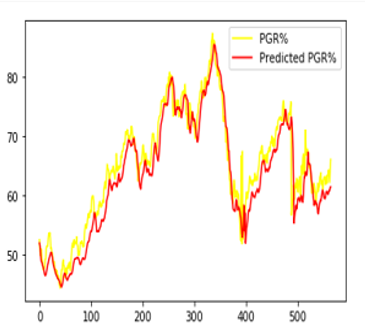